**ShopAssist AI 2.0**

>Given a dataset containing information about laptops (product names, specifications, descriptions, etc.), build a chatbot that parses the dataset and provides accurate laptop recommendations based on user requirements.

>We have a dataset laptop_data.csv where each row describes the features of a single laptop and also has a small description at the end. The chatbot will leverage large language models to parse this Description column and provide recommendations.





Installing Python Libraries


In [11]:
#Install OpenAI library
#!pip install -U -q openai tenacity pandas numpy

# Import needed libraries & dataset

In [1]:
import os
import re
import ast
import json
import openai
import pandas as pd
from IPython.display import display, HTML
from tenacity import retry, wait_random_exponential, stop_after_attempt

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.width', 100)

In [4]:
openai.api_key = open("OPENAI_API_Key.txt", "r").read().strip()
os.environ['OPENAI_API_KEY'] = openai.api_key

In [5]:
data_source_file = 'laptop_data.csv'
if os.path.isfile(data_source_file):
    df = pd.read_csv(data_source_file)
else:
    raise FileNotFoundError(f"No file by name {data_source_file} found")

In [6]:
df.head()

,Brand,Model Name,Core,CPU Manufacturer,Clock Speed,RAM Size,Storage Type,Display Type,Display Size,Graphics Processor,Screen Resolution,OS,Laptop Weight,Special Features,Warranty,Average Battery Life,Price,Description
0,Dell,Inspiron,i5,Intel,2.4 GHz,8GB,SSD,LCD,"15.6""",Intel UHD,1920x1080,Windows 10,2.5 kg,Backlit Keyboard,1 year,6 hours,"35,000",The Dell Inspiron is a versatile laptop that c...
1,MSI,GL65,i7,Intel,2.6 GHz,16GB,HDD+SSD,IPS,"15.6""",NVIDIA GTX,1920x1080,Windows 10,2.3 kg,RGB Keyboard,2 years,4 hours,"55,000",The MSI GL65 is a high-performance laptop desi...
2,HP,EliteBook,i7,Intel,2.8 GHz,16GB,SSD,LED,"14""",Intel UHD,1920x1080,Windows 11,1.5 kg,Fingerprint Sensor,3 years,8 hours,"90,000",The HP EliteBook is a premium laptop designed ...
3,Lenovo,IdeaPad,i3,Intel,2.1 GHz,8GB,HDD,TN,"15.6""",Intel UHD,1366x768,Windows 10,2.2 kg,Dolby Audio,1 year,5 hours,"25,000",The Lenovo IdeaPad is a versatile laptop that ...
4,ASUS,ZenBook Pro,i9,Intel,3.1 GHz,64GB,SSD,OLED,"15.6""",NVIDIA RTX,3840x2160,Windows 10,1.8 kg,NanoEdge Display,2 years,7 hours,"200,000",The ASUS ZenBook Pro is a high-end laptop that...


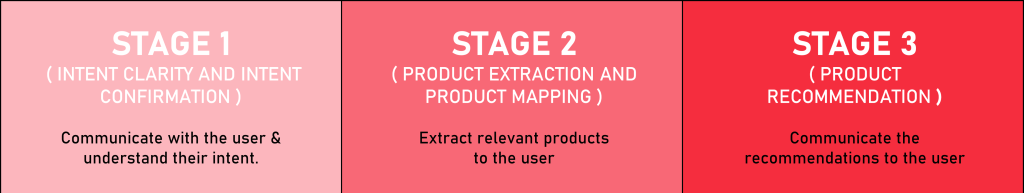



```

```



# System Design

`Stage 1`
- Intent Clarity Layer
- Intent Confirmation Layer

`Stage 2`

- Product Mapping Layer
- Product Information Extraction Layer

`Stage 3`
- Product Recommendation Layer

  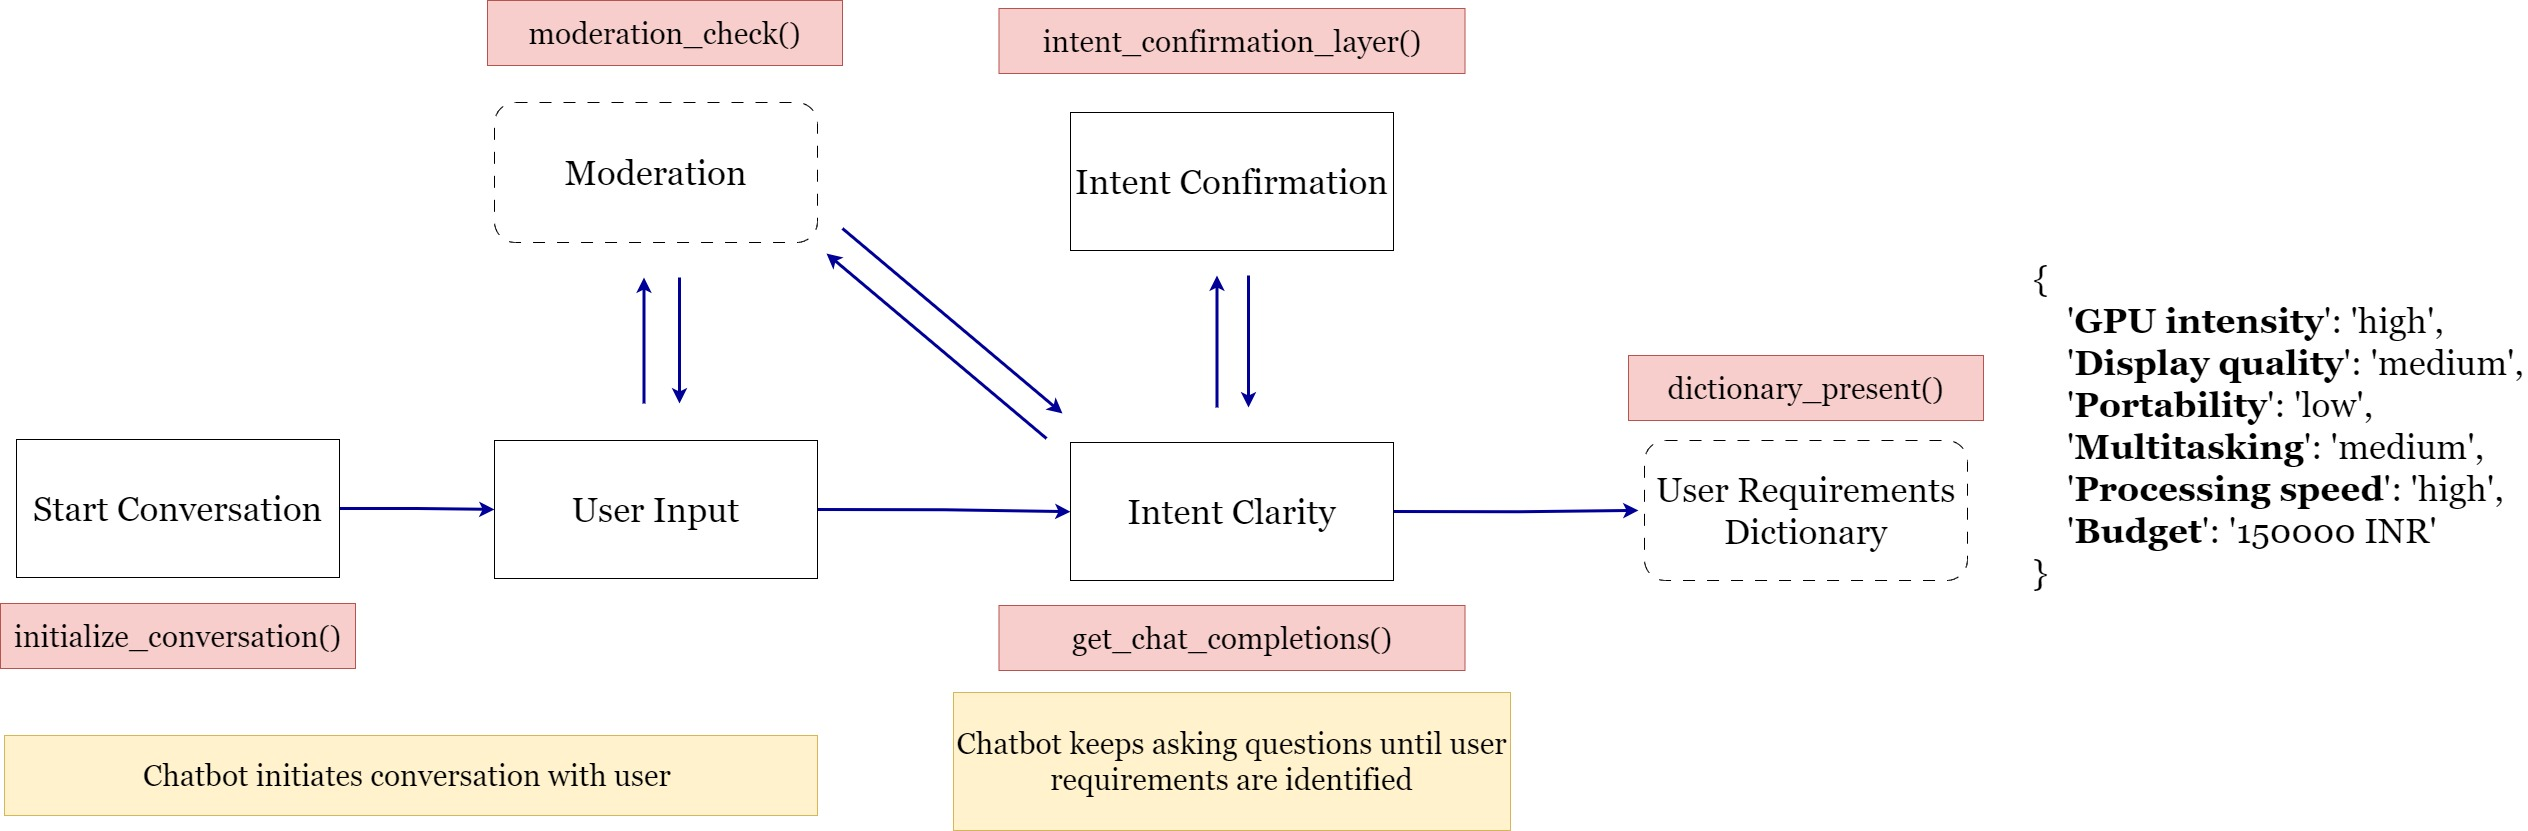




# Stage-1

## start conversation


```
def initialize_conversation():

```
This initializes the variable conversation with the system message. Using prompt engineering and chain of thought reasoning, the function will enable the chatbot to keep asking questions until the user requirements have been captured in a dictionary. It also includes Few Shot Prompting(sample conversation between the user and assistant) to align the model about user and assistant responses at each step.


In [26]:
# This function initiates create the system and role conversation with Open AI model
def initialize_conversation():
    '''
    Returns a list [{"role": "system", "content": system_message}]
    '''

    delimiter = "####"

    example_user_dict = {
        'CPU': "High",
        'GPU': "Medium",
        'Display Quality':"High",
        'Portability': "Low",
        'Multitasking': "Medium",
        'Budget': "150000"
    }

    example_user_req = {
        'CPU': "_",
        'GPU': "_",
        'Display Quality': "_",
        'Portability': "_",
        'Multitasking': "_",
        'Budget': "_"
    }

    system_message = f"""

    You are an intelligent laptop gadget expert and your goal is to find the best laptop for a user.
    You need to ask relevant questions and understand the user profile by analysing the user's responses.
    You final objective is to find the values for the different keys ('GPU intensity','Display quality','Portability','Multitasking','Processing speed','Budget') in the final string and be confident of the values.
    The values for these keys determine the users profile
    The string should look like I need a laptop with high GPU intensity, high Display quality, high Portablity, high Multitasking, high Prcoessing speed and a budget of 150000.
    The values for all keys, except 'budget', should be 'low', 'medium', or 'high' based on the importance of the corresponding keys, as stated by user.
    The value for 'budget' should be a numerical value extracted from the user's response.
    The values currently in the string provided are only representative values.

    {delimiter}Here are some instructions around the values for the different keys. If you do not follow this, you'll be heavily penalised.
    - The values for all keys, except 'Budget', should strictly be either 'low', 'medium', or 'high' based on the importance of the corresponding keys, as stated by user.
    - The value for 'budget' should be a numerical value extracted from the user's response.
    - 'Budget' value needs to be greater than or equal to 25000 INR. If the user says less than that, please mention that there are no laptops in that range.
    - Do not randomly assign values to any of the keys. The values need to be inferred from the user's response.
    {delimiter}

    To fill the values in the string, you need to have the following chain of thoughts:
    {delimiter} Thought 1: Ask a question to understand the user's profile and requirements. \n
    If their primary use for the laptop is unclear. Ask another question to comprehend their needs.
    You are trying to fill the values of all the keys ('GPU intensity','Display quality','Portability','Multitasking','Processing speed','Budget') in the string by understanding the user requirements.
    Identify the keys for which you can fill the values confidently using the understanding. \n
    Remember the instructions around the values for the different keys.
    Answer "Yes" or "No" to indicate if you understand the requirements and have updated the values for the relevant keys. \n
    If yes, proceed to the next step. Otherwise, rephrase the question to capture their profile. \n{delimiter}

    {delimiter}Thought 2: Now, you are trying to fill the values for the rest of the keys which you couldn't in the previous step.
    Remember the instructions around the values for the different keys. Ask questions you might have for all the keys to strengthen your understanding of the user's profile.
    Answer "Yes" or "No" to indicate if you understood all the values for the keys and are confident about the same.
    If yes, move to the next Thought. If no, ask question on the keys whose values you are unsure of. \n
    It is a good practice to ask question with a sound logic as opposed to directly citing the key you want to understand value for.{delimiter}

    {delimiter}Thought 3: Check if you have correctly updated the values for the different keys in the python dictionary.
    If you are not confident about any of the values, ask clarifying questions. {delimiter}

    Follow the above chain of thoughts and only output the final updated python dictionary. \n


    {delimiter} Here is a sample conversation between the user and assistant:
    User: "Hi, I am an editor."
    Assistant: "Great! As an editor, you likely require a laptop that can handle demanding tasks. Hence, the laptop should have high multitasking capability. You would also need a high end display for better visuals and editing. May I know what kind of work do you primarily focus on? Are you more involved in video editing, photo editing, or both? Understanding the specific type of editing work will help me tailor my recommendations accordingly. Let me know if my understanding is correct until now."
    User: "I primarily work with After Effects."
    Assistant: "Thank you for providing that information. Working with After Effects involves working with graphics, animations, and rendering, which will require high GPU. Do you work with high-resolution media files, such as 4K videos or RAW photos? Understanding your file sizes will help determine the storage capacity and processing power needed."
    User: "Yes, sometimes I work with 4K videos as well."
    Assistant: "Thank you for the information. Processing 4K vidoes will require a good processor and high GPU. I think we have already determined earlier that you need a high GPU. To ensure I have a complete understanding of your needs, I have one more question: Are you frequently on the go and require a laptop that is lightweight and easy to carry, or do you primarily work from a stationary location?"
    User: "Yes, sometimes I travel but do not carry my laptop."
    Assistant:"Could you kindly let me know your budget for the laptop? This will help me find options that fit within your price range while meeting the specified requirements."
    User: "my max budget is 1.5lakh inr"
    Assistant: "{example_user_req}"
    {delimiter}

    Start with a short welcome message and encourage the user to share their requirements.
    """
    conversation = [{"role": "system", "content": system_message}]
    # conversation = system_message
    return conversation

In [27]:
debug_conversation = initialize_conversation()

In [28]:
# check the function
print(debug_conversation[0]["content"])



    You are an intelligent laptop gadget expert and your goal is to find the best laptop for a user.
    You need to ask relevant questions and understand the user profile by analysing the user's responses.
    You final objective is to find the values for the different keys ('GPU intensity','Display quality','Portability','Multitasking','Processing speed','Budget') in the final string and be confident of the values.
    The values for these keys determine the users profile
    The string should look like I need a laptop with high GPU intensity, high Display quality, high Portablity, high Multitasking, high Prcoessing speed and a budget of 150000.
    The values for all keys, except 'budget', should be 'low', 'medium', or 'high' based on the importance of the corresponding keys, as stated by user.
    The value for 'budget' should be a numerical value extracted from the user's response.
    The values currently in the string provided are only representative values.

    ####Here are 

#intent clarity


```
def get_chat_model_completions(messages):
```
This takes the ongoing conversation as the input and returns the response by the assistant.This function perform LLM call using the Chat Completions API to get the LLM response.


In [29]:
# The function encapsulates the chat completions API call to Open AI
# Retry up to 6 times with exponential backoff, starting at 1 second and maxing out at 20 seconds delay
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_chat_model_completions(input, json_format=False):
    MODEL = 'gpt-3.5-turbo'

    # JSON Output
    if json_format == True:
        system_message_json_output = """<<. Return output in JSON format to the key output.>>"""
        # Append the input prompt to include JSON response as specified by OpenAI
        input[0]['content'] += system_message_json_output

        # JSON return type specified
        chat_completion_json = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            response_format = {"type": "json_object"},
            seed = 1234
        )
        output = json.loads(chat_completion_json.choices[0].message.content)

    # Non-JSON Output
    else:
        chat_completion = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            seed = 2345
        )
        output = chat_completion.choices[0].message.content

    return output

 ## Helper Function:



```
def iterate_response() :Calls a specified function repeatedly and prints the
     results.This function is designed to test the consistency of a response from a given function.
     It calls the function multiple times (default is 10) and prints out the iteration count,the function's response(s).

```




In [31]:
def iterate_response(funct, debug_response, num=10):
  for i in range (1, num+1):
        print(f"Iteration: {i}")
        response = funct(debug_response)
        print(response)
        print('#' * 50)

In [35]:
debug_user_input = "Hi, I am Rugved. I need a laptop for Gaming."
debug_conversation.append({"role": "user", "content": debug_user_input})


In [36]:
#print(debug_conversation[0]["content"]) # System Message
print(debug_conversation[1]["content"]) # User Input

Hi, I am Anand. I need a laptop for Gaming.


In [38]:
# Getting the response from the LLM Assistant by passing the conversation to the Chat Completions API
debug_response_assistant = get_chat_model_completions(debug_conversation)
display(debug_response_assistant)

'Great! As a gamer, you likely require a laptop with high GPU intensity for smooth gaming performance. Do you also value having a high-quality display for an immersive gaming experience?'

In [ ]:
# Let's append this to the conversation list
debug_conversation.append(({"role": "system", "content": debug_response_assistant}))


## Moderation
` def moderation_check(user_input):`This function will call OpenAI API to perform moderation check on the user's input.Any value below or equal to `user_value` passed as argument is marked as 1 else 0.And also checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, it ends the conversation.

In [41]:
def moderation_check(user_input):
  response = openai.moderations.create(input=user_input)
  moderation_output = response.results[0].flagged
  if response.results[0].flagged == True:
    return True
  else:
    return False

In [42]:
moderation_check(debug_user_input)


False

In [46]:
print(moderation_check("I want to kill someone"))
print(moderation_check("I need a laptop"))

True
False


Hence moderation function work perfectly.

## Intent confirmation

`def intent_confirmation_layer(response_assistant):
`: This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not:
- GPU intensity,
-Display quality,
-Portability,
-Multitasking,
-Processing speed,
-Budget

In [47]:
def intent_confirmation_layer(response_assistant):

    delimiter = "####"

    allowed_values = {'Low','Medium','High'}

    prompt = f"""
    You are a senior evaluator who has an eye for detail.The input text will contain a user requirement captured through 6 keys.
    You are provided an input. You need to evaluate if the input text has the following keys:
    {{
    'CPU':'values',
    'GPU':'values',
    'Display Quality':'values',
    'Portability':'values',
    'Multitasking':'values',
    'Budget':'number'
    }}
    The values for the keys should only be from the allowed values: {allowed_values}. Except, 'Budget' key can take only a numerical value which can be in string representation as well.
    Next you need to evaluate if the keys have the the values filled correctly.
    Only output a one-word string in JSON format at the key 'result' - Yes/No.
    Thought 1 - Output a string 'Yes' if the values are correctly filled for all keys, otherwise output 'No'.
    Thought 2 - If the answer is No, mention the reason in the key 'reason'.
    Thought 3 - Think carefully before the answering.
    """

    messages=[
        {"role": "system", "content":prompt },
        {"role": "user", "content":f"""Here is the input: {response_assistant}""" }
    ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages = messages,
        response_format={ "type": "json_object" },
        seed = 1234
    )

    json_output = json.loads(response.choices[0].message.content)

    return json_output

In [48]:
debug_response_assistant

'Great! As a gamer, you likely require a laptop with high GPU intensity for smooth gaming performance. Do you also value having a high-quality display for an immersive gaming experience?'

In [49]:
debug_confirmation = intent_confirmation_layer(debug_response_assistant)
display(debug_confirmation)

{'result': 'No',
 'reason': 'Missing key-value pairs for CPU, Display Quality, Portability, Multitasking, and Budget. Incorrect values for GPU.'}

## User Requirements Dictionary

`def dictionary_present(response):`: This function checks if the final understanding of user's profile is returned by the chatbot as a python dictionary or not. If there is a dictionary, it extracts the information as a Python dictionary

In [54]:
def dictionary_present(response):
    delimiter = "####"

    user_req = {
        'CPU': "High",
        'GPU': "Medium",
        'Display Quality':"High",
        'Portability': "Low",
        'Multitasking': "Medium",
        'Budget': 150000
    }

    prompt = f"""You are a python expert. You are provided an input.
    You have to check if there is a python dictionary present in the string.
    It will have the following format {user_req}.
    Your task is to just extract the relevant values from the input and return only the python dictionary in JSON format.
    The output should match the format as {user_req}.

    {delimiter}
    Make sure that the value of budget is also present in the user input. ###
    The output should contain the exact keys and values as present in the input.
    Ensure the keys and values are in the given format:
    {{
    'CPU': 'Low/Medium/High'
    'GPU': 'Low/Medium/High',
    'Display Quality':'Low/Medium/High',
    'Portability':'Low/Medium/High',
    'Multitasking':'Low/Medium/High',
    'Processing speed':'Low/Medium/High',
    'Budget':'Numerical Value without any comma'
    }}
    Here are some sample input output pairs for better understanding:
    {delimiter}
    input 1: CPU: Low - GPU: Low - Display Quality: High - Portability: Low - Multitasking: High - Budget: 50000
    output 1: {{'CPU':'Low', GPU': 'Low', 'Display Quality': 'High', 'Portability': 'Low', 'Multitasking': 'High', 'Budget': 50000}}

    input 2: CPU: Low - GPU: High - Display Quality: High - Portability: Medium - Multitasking: High - Budget: 90000
    output 2: {{'CPU':'Low', GPU': 'High', 'Display Quality': 'High', 'Portability': 'Medium', 'Multitasking': 'High', 'Budget': 90000}}

    input 2: CPU: High - GPU: High - Display Quality: High - Portability: Low - Multitasking: High - Budget: 125000
    output 2: {{'CPU':'High', GPU': 'High', 'Display Quality': 'High', 'Portability': 'Low', 'Multitasking': 'High', 'Budget': 125000}}
    {delimiter}
    """
    messages = [
        {"role": "system", "content":prompt },
        {"role": "user", "content":f"""Here is the user input: {response}""" }
    ]
    confirmation = get_chat_model_completions(messages, json_format = True)
    return confirmation

In [51]:
shop_response_assistant = """
{'GPU intensity':'high',
 'Display quality':'med',
 'Portability':'low',
 'Multitasking':'low',
 'Processing speed':'med',
 'Budget':'90000'}
"""

In [57]:
response_dict = dictionary_present(shop_response_assistant)
response_dict

{'GPU': 'high',
 'Display Quality': 'med',
 'Portability': 'low',
 'Multitasking': 'low',
 'Processing speed': 'med',
 'Budget': 90000}

In [58]:
type(response_dict)

dict

In [ ]:
# Check for LLM function's consistency
#iterate_response(dictionary_present, shop_response_assistant)

#Stage 2
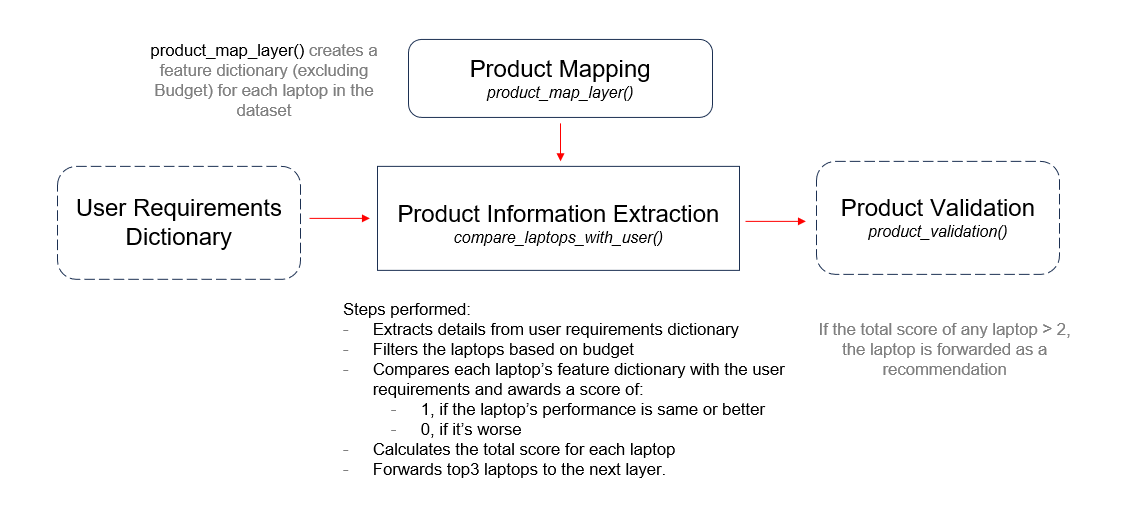


The second stage of the system is the ‘Product Mapping and Information Extraction’ stage. This stage filters the laptops as per the user requirements dictionary captured in the previous stage and uses it to present the top three laptop recommendations to the user.

## Product Mapping

`def product_map_layer(laptop_description):`Use a prompt that assign it the role of a Laptop Specifications Classifier, whose objective is to extract key features and classify them based on laptop descriptions.Assign specific rules for each feature (e.g., GPU Intensity, Display Quality, Portability, Multitasking, Processing Speed) and associate them with the appropriate classification value (Low, Medium, or High).

In [70]:
def product_map_layer(laptop_description):

  delimiter = "#####"

  lap_spec = {
        "CPU": "(CPU Performance)",
        "GPU": "(GPU Performance)",
        "Display Quality": "(Resolution of Display)",
        "Portability": "(Laptop Weight)",
        "Multitasking": "(RAM Size)",
        "Budget": "(Price of laptop)"
    }

  values = {'Low', 'Medium', 'High'}

  prompt=f"""
    You are a intelligent laptop buying assitant who is an expert in extracting features of a laptop from the provided laptop description data
    To extract features from laptop description, it is must to adhere to following steps:

    Step 1: Extract the laptop's primary features from the description as follows: {laptop_description}
    Step 2: Store the extracted features in {lap_spec} \
    Step 3: Classify each of the items in {lap_spec} into {values} based on the following rules: \

  {delimiter}
    GPU:
    - Low: <<< if GPU is an entry-level such as an integrated graphics processor or entry-level dedicated graphics like Intel UHD >>> , \n
    - Medium: <<< if mid-range dedicated graphics like M1, AMD Radeon, Intel Iris >>> , \n
    - High: <<< high-end dedicated graphics like Nvidia RTX or NVIDIA GTX series >>> , \n

    CPU:
    - Low: <<< if CPU is an entry-level processor like AMD Athlon, Intel Celeron, Intel Core 2 Duo >>> , \n
    - Medium: <<< if mid-range processor like Intel Core i3, Intel Core i5, AMD Ryzen 3 or AMD Ryzen 5 >>> , \n
    - High: <<< if a high-end processor like Intel Core i7, Intel Core i9, AMD Ryzen 7, AMD Ryzen 9 or Apple Series of Processors>>> , \n

    Display Quality:
    - Low: <<< if resolution is below Full HD (e.g., 1366x768). >>> , \n
    - Medium: <<< if Full HD resolution (1920x1080) or higher. >>> , \n
    - High: <<< if High-resolution display (e.g., 4K, Retina) with excellent color accuracy and features like HDR support. >>> \n

    Portability:
    - High: <<< if laptop weight is less than or equal to 1.0 kg >>> , \n
    - Medium: <<< if laptop weight is between 1.0 kg and 2.0 kg >>> , \n
    - Low: <<< if laptop weight is greater than or equal to 2.0 kg >>> \n
    Classifying laptops on the basis of portability has to adhere with mentioned rules and are to be be done followed very strictly

    Multitasking:
    - Low: <<< If RAM size is less than or equal to 8 GB >>> , \n
    - Medium: <<< if RAM size is between 9 GB & 16 GB >>> , \n
    - High: <<< if RAM size is greater than 20 GB >>> \n

    Budget:
    Extract the price of the laptop which is mentioned in Indian Rupee and convert the same into proper integer format so that it can be analyzed further.
    Be very careful while extracting price of the product. In case, if you are unable to extract the price mention the price as 0


  {delimiter}

  {delimiter}
    Here is input output pair for few-shot learning:
    input 1: "The Dell Inspiron is a versatile laptop that combines powerful performance and affordability. It features an Intel Core i5 processor clocked at 2.4 GHz, ensuring smooth multitasking and efficient computing. With 8GB of RAM and an SSD, it offers quick data access and ample storage capacity. The laptop sports a vibrant 15.6" LCD display with a resolution of 1920x1080, delivering crisp visuals and immersive viewing experience. Weighing just 2.5 kg, it is highly portable, making it ideal for on-the-go usage. Additionally, it boasts an Intel UHD GPU for decent graphical performance and a backlit keyboard for enhanced typing convenience. With a one-year warranty and a battery life of up to 6 hours, the Dell Inspiron is a reliable companion for work or entertainment. All these features are packed at an affordable price of 35,000, making it an excellent choice for budget-conscious users."
    output 1: {{'CPU': 'Medium', 'GPU':'Medium', 'Display Quality': 'Medium', 'Portability':'Low', 'Multitasking':'Low', 'Budget': 35000}}

  {delimiter}
    ### Strictly don't keep any other text in the values of the JSON dictionary other than Low, Medium or High else will be heavily penalized###
    """
  input = f"""Follow the above instructions step-by-step and output the dictionary in JSON format {lap_spec} for the following laptop {laptop_description}."""
    #see that we are using the Completion endpoint and not the Chatcompletion endpoint
  messages=[{"role": "system", "content":prompt },{"role": "user","content":input}]

  response = get_chat_model_completions(messages, json_format = True)

  return response


In [71]:
def filter_data_by_budget(max_budget_value=None):
    """
    This function will filter only those rows which has a budget lesser than the argument `max_budget_value` passed
    If no budget value is passed as argument, it means all rows are selected
    If the budget is selected such that after filtering no rows are present; then `False` is returned

    Parameters
    -------------
        max_budget_value : int
        This is the maximum budget selected

    Returns
    -------------
        temp_df : obj
        Returns pandas dataframe object with only those rows which has budget less than equal to `max_budget_value`

    """
    # pattern = r"(\d*)"
    # max_budget_value = int(re.search(pattern, max_budget_value.replace(",", "")).group())

    temp_df = df[df["Budget"] <= max_budget_value]
    if len(temp_df) == 0:
        return False
    else:
        return temp_df

In [72]:
def higher_the_better_rule(series, user_value):
    """
    This function will change specific dataframe column values as mentioned in argument `series`
    Any value above or equal to `user_value` passed as argument is marked as 1 else 0

    Parameters
    -------------
        series : obj
        Each column of pandas dataframe is passed as series

        user_value : str
        User value extracted from user for the particlular feature

    Returns
    -------------
        series : obj
        Return pandas series for that particular column

    """
    if user_value == "High":
        series_ = series.map({"High": 1.0, "Medium": 0.0, "Low": 0.0})
    elif user_value == "Medium":
        series_ = series.map({"High": 1.2, "Medium": 1, "Low": 0})
    elif user_value == "Low":
        series_ = series.map({"High": 1.5, "Medium": 1.2, "Low": 1})
    else:
        return False  #Inavlid user value

    return series_

In [73]:
def lower_the_better_rule(series, user_value):
    """
    This function will change specific dataframe column values as mentioned in argument `column_name`
    Any value below or equal to `user_value` passed as argument is marked as 1 else 0

    Parameters
    -------------
        series : obj
        Each column of pandas dataframe is passed as series

        user_value : str
        User value extracted from user for the particlular feature

    Returns
    -------------
        series : obj
        Return pandas series for that particular column

    """
    if user_value == "High":
        series_ = series.map({"High": 1, "Medium": 1.2, "Low": 1.5})
    elif user_value == "Medium":
        series_ = series.map({"High": 0, "Medium": 1, "Low": 1.2})
    elif user_value == "Low":
        series_ = series.map({"High": 0, "Medium": 0, "Low": 1})
    else:
        return False  #Inavlid user value

    return series_

In [74]:
df = pd.DataFrame(df["Description"], columns=["Description"])
df.head()

,Description
0,The Dell Inspiron is a versatile laptop that c...
1,The MSI GL65 is a high-performance laptop desi...
2,The HP EliteBook is a premium laptop designed ...
3,The Lenovo IdeaPad is a versatile laptop that ...
4,The ASUS ZenBook Pro is a high-end laptop that...


In [75]:
df["dict_"] = df["Description"].apply(product_map_layer)
df = pd.concat([df, df["dict_"].apply(pd.Series)], axis=1)
if "dict_" in df.columns:
    df = df.drop(columns=['dict_'])
df.head()

,Description,CPU,GPU,Display Quality,Portability,Multitasking,Budget
0,The Dell Inspiron is a versatile laptop that c...,Medium,Low,Medium,Low,Low,35000
1,The MSI GL65 is a high-performance laptop desi...,High,High,Medium,Medium,High,55000
2,The HP EliteBook is a premium laptop designed ...,High,Low,Medium,High,High,90000
3,The Lenovo IdeaPad is a versatile laptop that ...,Medium,Low,Low,Medium,Low,25000
4,The ASUS ZenBook Pro is a high-end laptop that...,High,High,High,High,High,200000


In [76]:
sample_user_query = {
    'CPU': 'Medium',
    'GPU': 'High',
    'Display Quality': 'Low',
    'Portability': 'High',
    'Multitasking': 'Medium',
    'Budget': 90000
}

In [77]:
df_after_budget_filter = filter_data_by_budget(sample_user_query["Budget"])

df_after_budget_filter["CPU"] = higher_the_better_rule(df_after_budget_filter["CPU"], sample_user_query["CPU"])
df_after_budget_filter["GPU"] = higher_the_better_rule(df_after_budget_filter["GPU"], sample_user_query["GPU"])
df_after_budget_filter["Display Quality"] = higher_the_better_rule(df_after_budget_filter["Display Quality"], sample_user_query["Display Quality"])
df_after_budget_filter["Portability"] = lower_the_better_rule(df_after_budget_filter["Portability"], sample_user_query["Portability"])
df_after_budget_filter["Multitasking"] = higher_the_better_rule(df_after_budget_filter["Multitasking"], sample_user_query["Multitasking"])
df_after_budget_filter["Score"] = df_after_budget_filter["CPU"] + df_after_budget_filter["GPU"] + df_after_budget_filter["Display Quality"] + df_after_budget_filter["Portability"] + df_after_budget_filter["Multitasking"]

df_after_budget_filter = df_after_budget_filter.sort_values(by=["Score", "Budget"], ascending=[False, True], ignore_index=True)
df_after_budget_filter.head(3)

,Description,CPU,GPU,Display Quality,Portability,Multitasking,Budget,Score
0,The Acer Predator is a powerhouse laptop desig...,1.2,1.0,1.2,1.5,1.2,80000,6.1
1,The Lenovo ThinkPad is a powerful laptop desig...,1.2,1.0,1.5,1.0,1.2,60000,5.9
2,The MSI GL65 is a high-performance laptop desi...,1.2,1.0,1.2,1.2,1.2,55000,5.8


#  Stage - 3
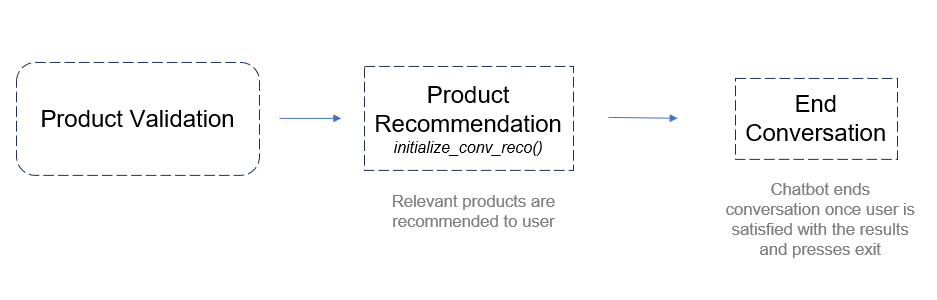




## Product Recomendation

` def initialize_conv_reco(products)`:This function will interact with user in an engaging manner such that user should be able to understand all the `shortlisted` laptops which were provided by earler stages


In [80]:
def initialize_conv_reco(products):
    system_message = f"""
    You are an intelligent laptop gadget expert and you are tasked with the objective to \
    solve the user queries about any product from the catalogue: {products}.\
    You should keep the user profile in mind while answering the questions.\

    Start with a brief summary of each laptop in the following format, in decreasing order of price of laptops:
    1. <Laptop Name> : <Major specifications of the laptop>, <Price in Rs>
    2. <Laptop Name> : <Major specifications of the laptop>, <Price in Rs>

    """
    user_message = f""" These are the user's products: {products}"""
    conversation = [
        {"role": "system", "content": system_message },
        {"role":"user","content":user_message}
    ]
    return conversation


In [82]:
#Let's initialize the conversation for recommendation.

debug_conversation_reco = initialize_conv_reco(list(df_after_budget_filter.head(3)["Description"].values))
debug_recommendation = get_chat_model_completions(debug_conversation_reco)
print(debug_recommendation + '\n')

Sure, here are brief summaries of each laptop in decreasing order of price:

1. Acer Predator: Intel Core i7 processor at 2.8 GHz, 16GB RAM, SSD, 17.3" IPS display (1920x1080), NVIDIA GTX graphics card, 3.2 kg, dual cooling fans, 1-year warranty, 5-hour battery life. Price: Rs 80,000.

2. Lenovo ThinkPad: Ryzen 7 processor at 3.0 GHz, 16GB RAM, SSD, 14" IPS display (2560x1440), NVIDIA GTX graphics card, 1.6 kg, backlit keyboard, 3-year warranty, 6-hour battery life. Price: Rs 60,000.

3. MSI GL65: Intel Core i7 processor at 2.6 GHz, 16GB RAM, HDD & SSD storage, 15.6" IPS display (1920x1080), NVIDIA GTX graphics card, 2.3 kg, RGB keyboard, 2-year warranty, 4-hour battery life. Price: Rs 55,000.

If you have any specific questions or need further details, feel free to ask!



In [84]:
debug_user_input = "Which is ideal for Gaming and productivity"

debug_conversation_reco.append({"role": "user", "content": debug_user_input})
debug_response_asst_reco = get_chat_model_completions(debug_conversation_reco)
display('\n' + debug_response_asst_reco + '\n')

'\nHere is a summary of the laptops in descending order of price:\n\n1. Acer Predator:\n   - Processor: Intel Core i7 2.8 GHz\n   - RAM: 16GB\n   - Storage: SSD\n   - Display: 17.3" IPS 1920x1080\n   - Graphics: NVIDIA GTX\n   - Weight: 3.2 kg\n   - Warranty: 1 year\n   - Battery Life: Up to 5 hours\n   - Price: Rs. 80,000\n\n2. Lenovo ThinkPad:\n   - Processor: Ryzen 7 3.0 GHz\n   - RAM: 16GB\n   - Storage: SSD\n   - Display: 14" IPS 2560x1440\n   - Graphics: NVIDIA GTX\n   - Weight: 1.6 kg\n   - Warranty: 3 years\n   - Battery Life: Up to 6 hours\n   - Price: Rs. 60,000\n\n3. MSI GL65:\n   - Processor: Intel Core i7 2.6 GHz\n   - RAM: 16GB\n   - Storage: HDD and SSD\n   - Display: 15.6" IPS 1920x1080\n   - Graphics: NVIDIA GTX\n   - Weight: 2.3 kg\n   - Warranty: 2 years\n   - Battery Life: Up to 4 hours\n   - Price: Rs. 55,000\n\nFor a balance between gaming and productivity, the Lenovo ThinkPad would be an ideal choice. It offers strong processing capabilities for demanding tasks, 

>## **AI Shop assistant**


shop_assist_AI= stage1 + stage2 + stage3





In [90]:
def dialogue_shop_assist():
    conversation = initialize_conversation()
    introduction = get_chat_model_completions(conversation)
    display(introduction + '\n')
    top_3_laptops = None
    user_input = ''
    while(user_input != "exit"):
        user_input = input("")

        moderation = moderation_check(user_input)
        if moderation == 'Flagged':
            display("Sorry, this message has been flagged. Please restart your conversation.")
            break

        if top_3_laptops is None:
            conversation.append({"role": "user", "content": user_input})
            response_assistant = get_chat_model_completions(conversation)
            moderation = moderation_check(response_assistant)
            if moderation == 'Flagged':
                display("Sorry, this message has been flagged. Please restart your conversation.")
                break

            confirmation = intent_confirmation_layer(response_assistant)
            if "No" in confirmation.get('result'):
                conversation.append({"role": "assistant", "content": str(response_assistant)})
                print("\n" + str(response_assistant) + "\n")

            else:
                response = dictionary_present(response_assistant)

                print("Thank you for providing all the information. Kindly wait, while I fetch the products: \n")
                top_3_laptops = compare_laptops_with_user(response)
                print("Top 3 laptops are", top_3_laptops)
                validated_reco = recommendation_validation(top_3_laptops)

                df_after_budget_filter = filter_data_by_budget(response["Budget"])

                df_after_budget_filter["CPU"] = higher_the_better_rule(df_after_budget_filter["CPU"], response["CPU"])
                df_after_budget_filter["GPU"] = higher_the_better_rule(df_after_budget_filter["GPU"], response["GPU"])
                df_after_budget_filter["Display Quality"] = higher_the_better_rule(df_after_budget_filter["Display Quality"], response["Display Quality"])
                df_after_budget_filter["Portability"] = lower_the_better_rule(df_after_budget_filter["Portability"], response["Portability"])
                df_after_budget_filter["Multitasking"] = higher_the_better_rule(df_after_budget_filter["Multitasking"], response["Multitasking"])
                df_after_budget_filter["Score"] = df_after_budget_filter["CPU"] + df_after_budget_filter["GPU"] + df_after_budget_filter["Display Quality"] + df_after_budget_filter["Portability"] + df_after_budget_filter["Multitasking"]

                df_after_budget_filter = df_after_budget_filter.sort_values(by=["Score", "Budget"], ascending=[False, True], ignore_index=True)


                conversation_reco = initialize_conv_reco(list(df_after_budget_filter.head(3)["Description"].values))
                conversation_reco.append({"role": "user", "content": "This is my user profile" + str(response)})
                recommendation = get_chat_model_completions(conversation_reco)
                moderation = moderation_check(recommendation)
                if moderation == 'Flagged':
                    display("Sorry, this message has been flagged. Please restart your conversation.")
                    break
                conversation_reco.append({"role": "assistant", "content": str(recommendation)})
                print(str(recommendation) + '\n')
        else:
            conversation_reco.append({"role": "user", "content": user_input})
            response_asst_reco = get_chat_model_completions(conversation_reco)
            moderation = moderation_check(response_asst_reco)
            if moderation == 'Flagged':
                print("Sorry, this message has been flagged. Please restart your conversation.")
                break
            print('\n' + response_asst_reco + '\n')
            conversation.append({"role": "assistant", "content": response_asst_reco})

In [91]:

dialogue_shop_assist()


"Hello! I'm here to help you find the best laptop that suits your needs. Please share your requirements with me so that I can assist you in finding the perfect match.\n"

editing vedio

Great! As a video editor, you likely require a laptop that can handle demanding tasks. Hence, the laptop should have high multitasking capability. You would also need a high-end display for better visuals and editing. May I know if you primarily focus on video editing, photo editing, or both? Understanding the specific type of editing work will help me tailor my recommendations accordingly. Let me know if my understanding is correct until now.

video editing and video editing software for YouTube channel

Thank you for providing that information. Working with video editing software for YouTube channels involves editing, rendering, and processing video content, which will require high GPU intensity. Do you work with high-resolution media files, such as 4K videos or RAW footage? Understanding your file sizes will help determine the storage capacity and processing power needed.

more the better

Great! Based on your response, I can infer that you would require a laptop with